Example Copied from YouTube: Physics Informed Neural Networks explained for beginners | From scratch implementation and code

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# ------------------
# 1: Generate Synthetic Data 
# ------------------ 

# Initialize physics parameters (global variables)
g = 9.8         # acceleration due to gravity
v0 = 10.0   # initial velocity
h0 = 1.0    # initial height

# Ground-truth/analytical solution is h(t) = h0 + v0 -0.5 * g * t^2
def true_solution(t): # creates ideal dataset without noise
    return h0 + v0*t - 0.5*g*(t**2)

t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data) # grid of 10 datapoints using np.linspace (numpy array)

# Generate synthetic "experimental" heights with noise
np.random.seed(0) # seed for repeatable outputs
noise_level = 0.6 # how much we're perturbing the dataset
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert data to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1,1)  # model is fed input tensor
t_data_tensor.requires_grad_(True) # the x parameter in dh_dt_derivative(y, x) needs to have .requires_grad(True)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1,1) # model supposed to predict this tensor

In [22]:
# ------------------
# 2: Define a small feed-forward neural network for h(t) and structure
# ------------------ 
class PINN(nn.Module):
    def __init__(self, n_hidden=20): # n_hidden = num of neurons in hidden layer
        super(PINN, self).__init__()
    # Defining a simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden), # 1 input into 20 neurons
            nn.Tanh(), # activation function
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1) # 20 neurons into 1 output
        )
    
    def forward(self, t): # 'forward(self, t) is a required method, even the name, to process inputs when model() is used
        # Forward pass algorithm: input shape (batch_size, 1) -> output shape (batch_size, 1)
        return self.net(t)
    
# Instantiate the model
model = PINN(n_hidden=20)

In [23]:
# ------------------
# 3: Helper function for automatic differentiation
# ------------------ 
# Computes dy/dx using PyTorch's autograd.
# y and x must be tensors with requires_grad=True for x

def dh_dt_derivative(y,x):
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

# returns the output of the automatic differentiation by
# differentiating the neural network at any point h & t

In [27]:
# ------------------
# 3: Define Loss Components/Functions for PINN
# ------------------

# We have 3 losses...
# loss due to predicted data and experimental data (noisy data + parabolic data)
# loss due to ODE via predicted dh/dt and actual dh/dt (dh/dt = v0 - g * t)
# loss due to the predicted intiial condition and actual initial condition (height)

def data_loss(model, t_data, h_data):
    # MSE between predicted h(t_i) and noisy measurements h_data
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)
    
def physics_loss(model, t):
    # MSE ODE loss
    # Compare d(h_pred)/dt with the known expression v0 - g*t (dh/dt)
    h_pred = model(t)
    dh_dt_pred = dh_dt_derivative(h_pred, t)
    
    # Known physics, for each t we apply v0 - g * t (dh/dt)
    dh_dt_true = v0 - g * t
    
    loss_ode = torch.mean((dh_dt_true - dh_dt_pred)**2)
    return loss_ode
    
def initial_condition_loss(model):
    # MSE enforcing h(t=0) = h0, height at t=0 is the same as initial height
    # So, we need to evaluate at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()

In [25]:
# ------------------
# 5: Training Setup and Optimizer
# ------------------

# lr = learning rate = eta
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define hyperparameters for weighing loss terms (lambda)
lambda_data = 1.0
lambda_ode = 1.0
lambda_init_cond = 1.0

# Define loops/epochs for forward pass and backpropagation 
epochs = 1000

In [29]:
# ------------------
# 6: Training the Model 
# ------------------

model.train()

# Do the loops
for epoch in range(epochs):
    optimizer.zero_grad() # declare optimizer
    
    #compute losses
    loss_data = data_loss(model, t_data_tensor, h_data_tensor)
    loss_ode = physics_loss(model, t_data_tensor)
    loss_init_cond = initial_condition_loss(model)
    
    # Total loss computed
    loss_total = (lambda_data * loss_data) + (lambda_ode * loss_ode) + (lambda_init_cond * loss_init_cond)
    
    #Backpropagation
    loss_total.backward()
    optimizer.step()
    
    
        # Print losses
    if epoch % 100 == 0:
        print(
            f"Epoch #: {epoch}/{epochs} "
            f"Loss from the data = {loss_data} "
            f"Loss from the ODE = {loss_ode} "
            f"Loss from the initial condition = {loss_init_cond} "
            f"Calculated total loss = {loss_total} "
        )

Epoch #: 0/1000 Loss from the data = 0.35115939378738403 Loss from the ODE = 0.015489774756133556 Loss from the initial condition = 0.01012357510626316 Calculated total loss = 0.37677276134490967 
Epoch #: 100/1000 Loss from the data = 0.3505200445652008 Loss from the ODE = 0.015549151226878166 Loss from the initial condition = 0.010116979479789734 Calculated total loss = 0.37618619203567505 
Epoch #: 200/1000 Loss from the data = 0.3496447503566742 Loss from the ODE = 0.01570739969611168 Loss from the initial condition = 0.010122807696461678 Calculated total loss = 0.3754749596118927 
Epoch #: 300/1000 Loss from the data = 0.3487747609615326 Loss from the ODE = 0.015916431322693825 Loss from the initial condition = 0.010073979385197163 Calculated total loss = 0.37476518750190735 
Epoch #: 400/1000 Loss from the data = 0.34792304039001465 Loss from the ODE = 0.016093870624899864 Loss from the initial condition = 0.01000086311250925 Calculated total loss = 0.37401777505874634 
Epoch #: 

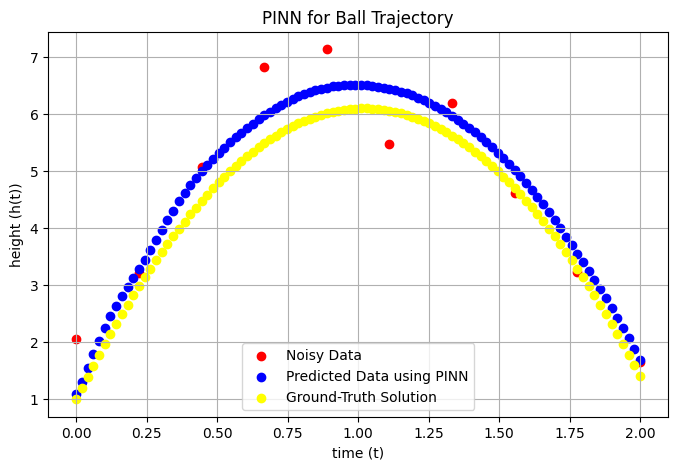

In [37]:
# ------------------
# 7: Evaluate the Model using Noisy Data
# ------------------

model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32) # x-axis, time values from 0-100
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

#True solution to compare on the graph
h_true_plot = true_solution(t_plot)

# Plot the results
plt.figure(figsize=(8,5))

# Plotting 3 graphs
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.scatter(t_plot, h_pred_plot, color='blue', label='Predicted Data using PINN')
plt.scatter(t_plot, h_true_plot,color='yellow', label='Ground-Truth Solution')

plt.xlabel('time (t)')
plt.ylabel('height (h(t))')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()
